In [1]:
import open3d as o3d
import numpy as np
import re
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ
# if running on Travis CI, the number of iterations is reduced
is_ci = "CI" in os.environ

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\RGBD\normal_map.npy already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\RGBD\raycast_vtx_004.npy already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\tests\bunnyData.pts already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\tests\point_cloud_sample1.pts already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\tests\point_cloud_sample2.pts already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads

# Color Map Optimization
Consider color mapping to the geometry reconstructed from depth cameras. As color and depth frames are not perfectly aligned, the texture mapping using color images is subject to results in blurred color map. Open3D provides color map optimization method proposed by [\[Zhou2014\]](../reference.html#zhou2014). The following script shows an example of color map optimization.

## Input
This code below reads color and depth image pairs and makes `rgbd_image`. Note that `convert_rgb_to_intensity` flag is `False`. This is to preserve 8-bit color channels instead of using single channel float type image.

It is always good practice to visualize the RGBD image before applying it to the color map optimization. The `debug_mode` switch can be set to `True` to visualize the RGBD image.

In [2]:
def load_fountain_dataset():

    def get_file_list(path, extension=None):

        def sorted_alphanum(file_list_ordered):
            convert = lambda text: int(text) if text.isdigit() else text
            alphanum_key = lambda key: [
                convert(c) for c in re.split('([0-9]+)', key)
            ]
            return sorted(file_list_ordered, key=alphanum_key)

        if extension is None:
            file_list = [
                path + f
                for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))
            ]
        else:
            file_list = [
                path + f
                for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f)) and
                os.path.splitext(f)[1] == extension
            ]
        file_list = sorted_alphanum(file_list)
        return file_list

    path = o3dtut.download_fountain_dataset()
    depth_image_path = get_file_list(os.path.join(path, "depth/"),
                                     extension=".png")
    color_image_path = get_file_list(os.path.join(path, "image/"),
                                     extension=".jpg")
    assert (len(depth_image_path) == len(color_image_path))

    rgbd_images = []
    for i in range(len(depth_image_path)):
        depth = o3d.io.read_image(os.path.join(depth_image_path[i]))
        color = o3d.io.read_image(os.path.join(color_image_path[i]))
        rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            color, depth, convert_rgb_to_intensity=False)
        rgbd_images.append(rgbd_image)

    camera_trajectory = o3d.io.read_pinhole_camera_trajectory(
        os.path.join(path, "scene/key.log"))
    mesh = o3d.io.read_triangle_mesh(
        os.path.join(path, "scene", "integrated.ply"))

    return mesh, rgbd_images, camera_trajectory

The code below reads a camera trajectory and a mesh.

In [3]:
# Load dataset
mesh, rgbd_images, camera_trajectory = load_fountain_dataset()

downloading fountain dataset
extract fountain dataset


To visualize how the camera poses are not good for color mapping, this code intentionally sets the iteration number to 0, which means no optimization. `color_map_optimization` paints a mesh using corresponding RGBD images and camera poses. Without optimization, the texture map is blurred.

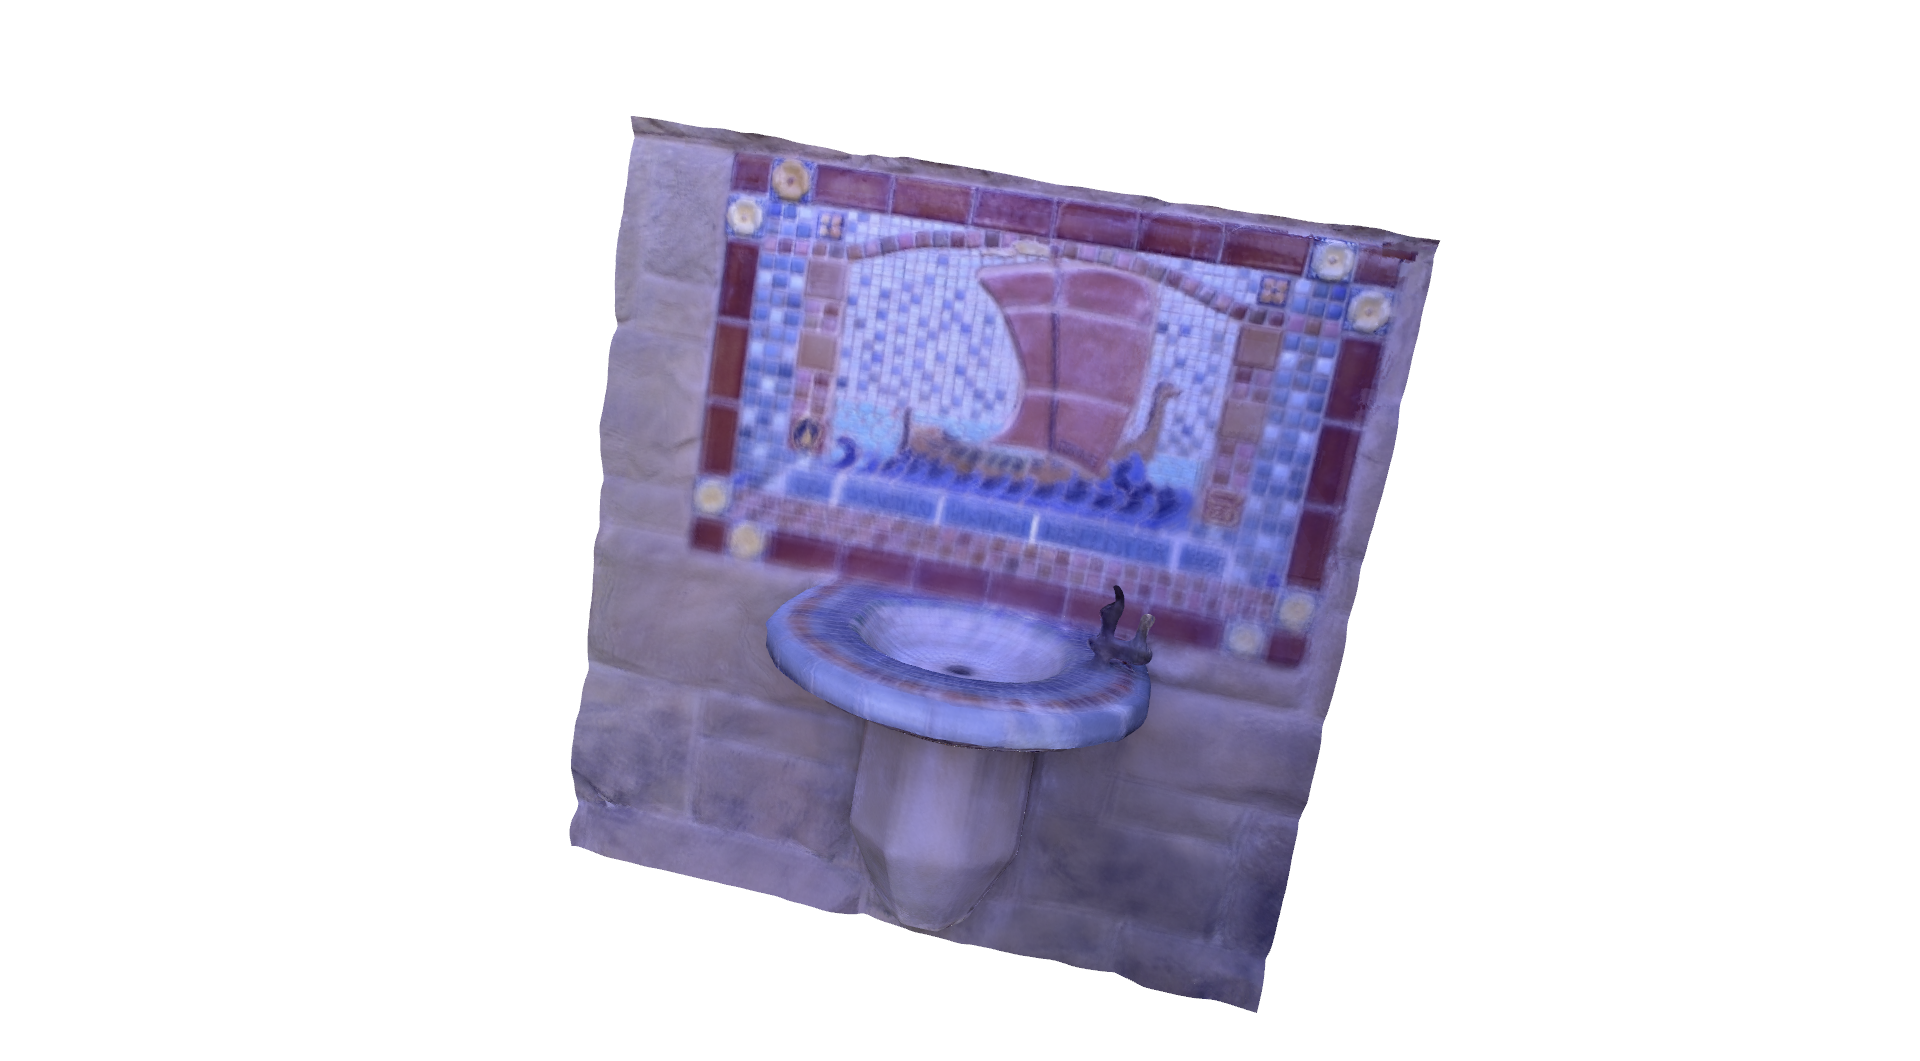

In [4]:
# Before full optimization, let's visualize texture map
# with given geometry, RGBD images, and camera poses.
mesh, camera_trajectory = o3d.pipelines.color_map.run_rigid_optimizer(
    mesh, rgbd_images, camera_trajectory,
    o3d.pipelines.color_map.RigidOptimizerOption(maximum_iteration=0))
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.5399,
                                  front=[0.0665, -0.1107, -0.9916],
                                  lookat=[0.7353, 0.6537, 1.0521],
                                  up=[0.0136, -0.9936, 0.1118])

## Rigid Optimization
The next step is to optimize camera poses to get a sharp color map.

The code below sets `maximum_iteration = 300` for actual iterations.

[Open3D DEBUG] [ColorMapOptimization] CreateUtilImagesFromRGBD
[Open3D DEBUG] [ColorMapOptimization] CreateDepthBoundaryMasks
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 0/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 1/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 2/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 3/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 4/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 5/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 6/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 7/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 8/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 9/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 10/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 11/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 12/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 13/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 14/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 15/33
[Open3D DEBUG] [Make

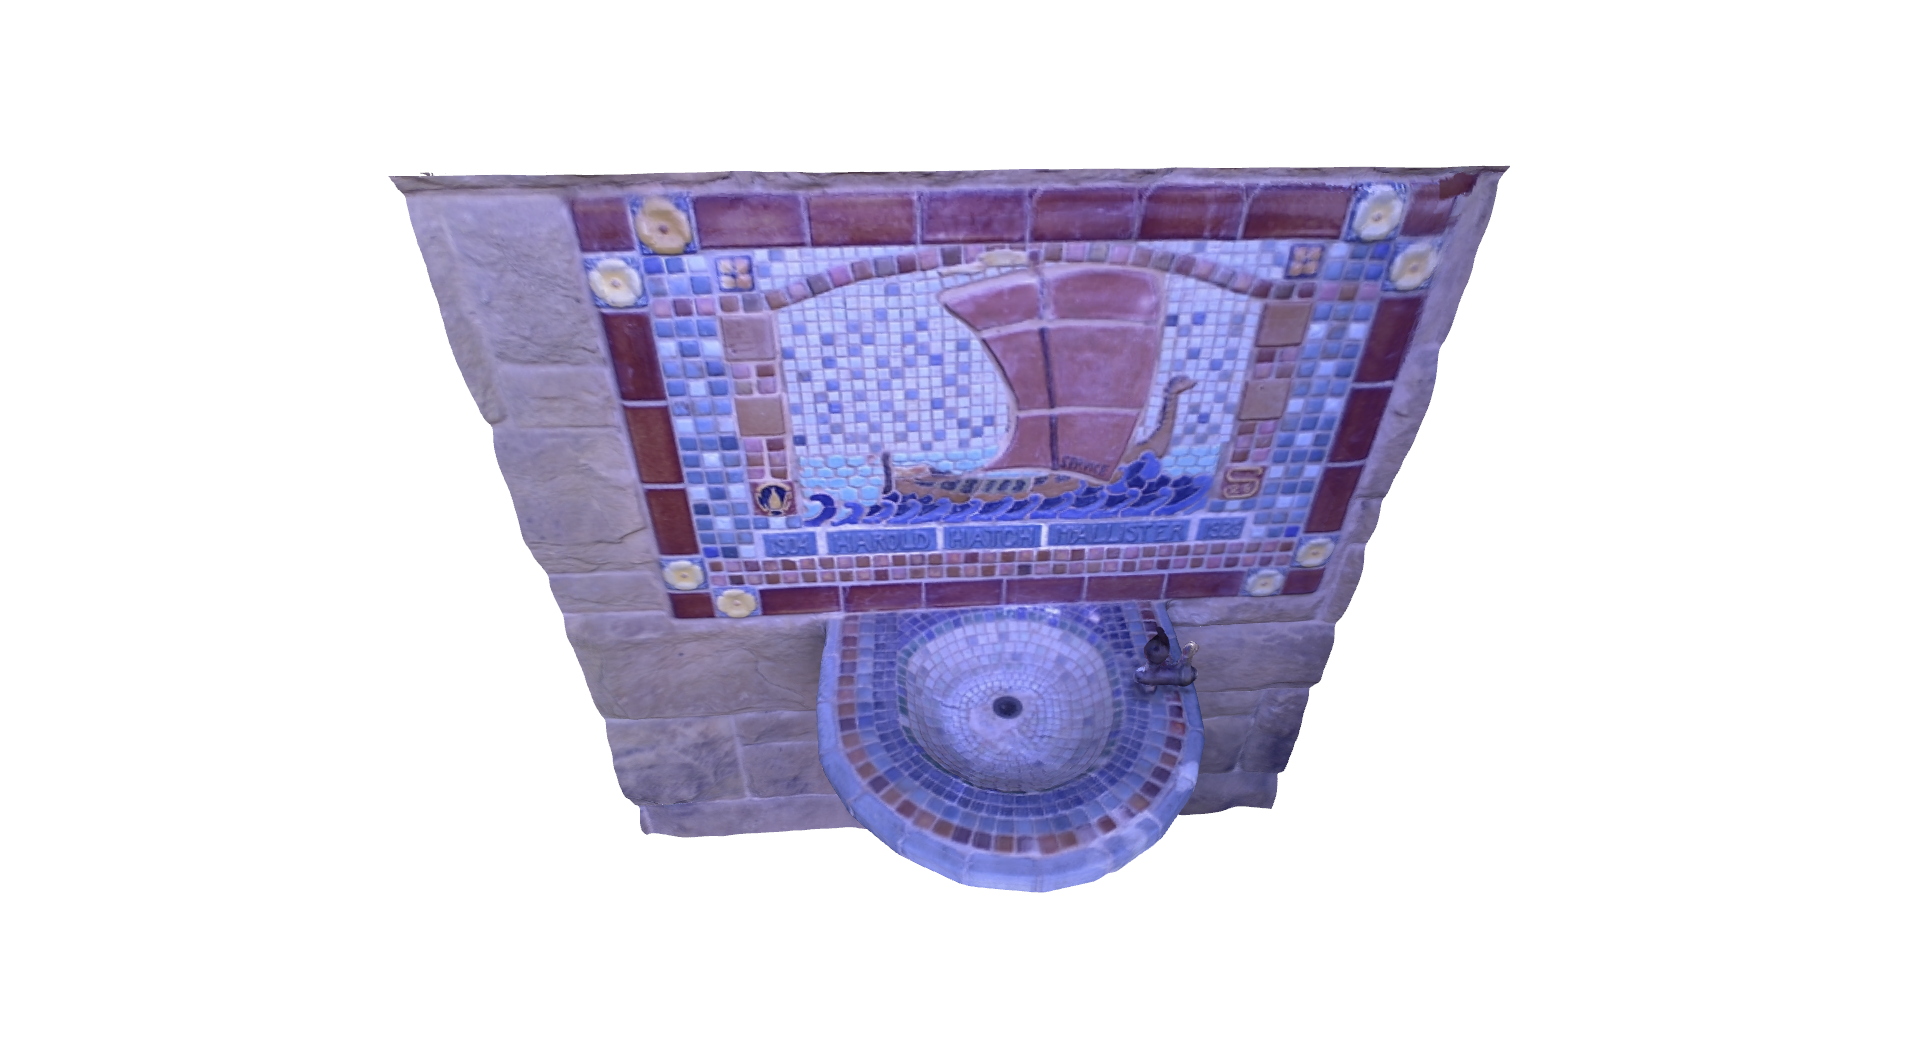

In [5]:
# Optimize texture and save the mesh as texture_mapped.ply
# This is implementation of following paper
# Q.-Y. Zhou and V. Koltun,
# Color Map Optimization for 3D Reconstruction with Consumer Depth Cameras,
# SIGGRAPH 2014

# Run rigid optimization.
maximum_iteration = 100 if is_ci else 300
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, camera_trajectory = o3d.pipelines.color_map.run_rigid_optimizer(
        mesh, rgbd_images, camera_trajectory,
        o3d.pipelines.color_map.RigidOptimizerOption(
            maximum_iteration=maximum_iteration))

o3d.visualization.draw_geometries([mesh],
                                  zoom=0.5399,
                                  front=[0.0665, -0.1107, -0.9916],
                                  lookat=[0.7353, 0.6537, 1.0521],
                                  up=[0.0136, -0.9936, 0.1118])

The residual error implies inconsistency of image intensities. Lower residual leads to a better color map quality. By default, `ColorMapOptimizationOption` enables rigid optimization. It optimizes 6-dimensional pose of every cameras.

## Non-rigid Optimization
For better alignment quality, there is an option for non-rigid optimization. To enable this option, simply set `option.non_rigid_camera_coordinate` to `True` before calling `color_map_optimization`. Besides 6-dimensional camera poses, non-rigid optimization even considers local image warping represented by anchor points. This adds even more flexibility and leads to an even higher quality color mapping. The residual error is smaller than the case of rigid optimization.

In [6]:
# Run non-rigid optimization.
maximum_iteration = 100 if is_ci else 300
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, camera_trajectory = o3d.pipelines.color_map.run_non_rigid_optimizer(
        mesh, rgbd_images, camera_trajectory,
        o3d.pipelines.color_map.NonRigidOptimizerOption(
            maximum_iteration=maximum_iteration))

[Open3D DEBUG] [ColorMapOptimization] CreateUtilImagesFromRGBD
[Open3D DEBUG] [ColorMapOptimization] CreateDepthBoundaryMasks
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 0/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 1/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 2/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 3/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 4/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 5/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 6/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 7/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 8/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 9/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 10/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 11/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 12/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 13/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 14/33
[Open3D DEBUG] [MakeDepthMasks] geometry::Image 15/33
[Open3D DEBUG] [Make

In [ ]:
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.5399,
                                  front=[0.0665, -0.1107, -0.9916],
                                  lookat=[0.7353, 0.6537, 1.0521],
                                  up=[0.0136, -0.9936, 0.1118])